In [13]:
#%matplotlib inline
import argparse
import os
import random
import pickle
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import tqdm

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


# MANGA Dataset
---

### Preprocessing

In [3]:
# Training and Validation data
transforms = v2.Compose([
    v2.Resize((64, 64)), # Resize to 224x224
    v2.ToTensor(),
    v2.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]), # Normalize
])

# Create Datasets for Training and Validation
PATH = '../animeface-character-dataset/animeface-character-dataset' 
train_dataset = ImageFolder(PATH, transform=transforms)

/Users/bhumikasrinivas/opt/anaconda3/envs/msds/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [4]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 9754
    Root location: ../animeface-character-dataset/animeface-character-dataset
    StandardTransform
Transform: Compose(
                 Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 ToTensor()
                 Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=False)
           )

In [5]:
# Create a DataLoader for batching and shuffling the data
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Generator
---

In [6]:
class Generator(nn.Module):
    def __init__(self, maps = 64, noise_size = 128):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(noise_size, maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(maps * 8),
            nn.ReLU(True),
            # state size. (maps*8) x 4 x 4
            nn.ConvTranspose2d(maps * 8, maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 4),
            nn.ReLU(True),
            # state size. (maps*4) x 8 x 8
            nn.ConvTranspose2d(maps * 4, maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 2),
            nn.ReLU(True),
            # state size. (maps*2) x 16 x 16
            nn.ConvTranspose2d(maps * 2, maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps),
            nn.ReLU(True),
            # state size. (maps) x 32 x 32
            nn.ConvTranspose2d(maps, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. 3 x 64 x 64
        )

    def forward(self, x):
        return self.model(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


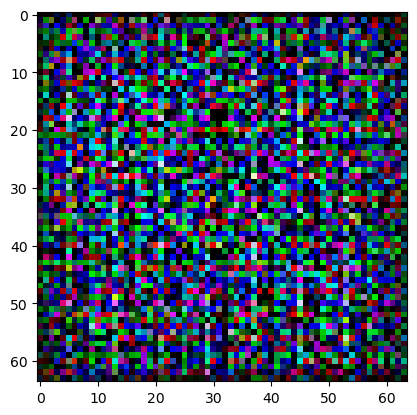

In [7]:
generator = Generator()
noise = torch.randn(64, 128, 1, 1)
output = generator(noise)
plt.imshow(output[0].detach().numpy().transpose(1, 2, 0))
plt.show()

# Discriminator
---

In [8]:
class Discriminator(nn.Module):
    def __init__(self, maps = 64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # input is (3) x 64 x 64
            nn.Conv2d(3, maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (maps) x 32 x 32
            nn.Conv2d(maps, maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (maps*2) x 16 x 16
            nn.Conv2d(maps * 2, maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (maps*4) x 8 x 8
            nn.Conv2d(maps * 4, maps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (maps*8) x 4 x 4
            nn.Conv2d(maps * 8, 1, 4, 1, 0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [9]:
# Instantiate the discriminator
discriminator = Discriminator()
output_discriminator = discriminator(output)
output_discriminator.shape

torch.Size([64, 1])

In [10]:
output.shape

torch.Size([64, 3, 64, 64])

# Compiler
---

In [ ]:
generator = Generator()
discriminator = Discriminator()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()


# Training Loop
num_epochs = 1
latent_size = 128

for epoch in tqdm.tqdm(range(num_epochs)):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images
        batch_size = real_images.size(0)

        # Create labels for real and fake images
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Train the generator
        g_optimizer.zero_grad()
        z = torch.randn(batch_size, latent_size, 1, 1)
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        g_optimizer.step()

        # Train the discriminator
        d_optimizer.zero_grad()
        real_outputs = discriminator(real_images)
        d_real_loss = criterion(real_outputs, real_labels)
        fake_outputs = discriminator(fake_images.detach())
        d_fake_loss = criterion(fake_outputs, fake_labels)
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], "
                  f"Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_loss.item():.4f}")

# Save the model checkpoints
with open('generator.pkl', 'wb') as f:
    pickle.dump(generator, f)

with open('discriminator.pkl', 'wb') as f:
    pickle.dump(discriminator, f)

# Model Evaluation
---

## Random Noise

In [ ]:
generator = pickle.load(open('generator.pkl', 'rb'))

torch.Size([4, 128, 1, 1])


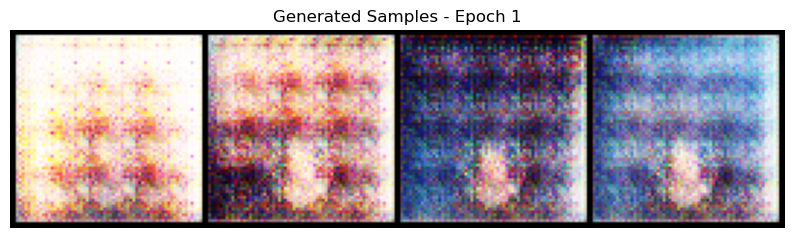

In [43]:
# Generate samples for visualization
with torch.no_grad():
    z = torch.randn(4, latent_size, 1, 1)
    print(z.shape)
    fake_samples = generator(z).reshape(-1, 3, 64, 64)
    # fake_samples = (fake_samples + 1) / 2
    
# Visualize generated samples
grid_img = vutils.make_grid(fake_samples, nrow=4, padding=2, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.title(f"Generated Samples - Epoch {epoch+1}")
plt.show()

## Real Images - ResNet50

In [56]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

# Load and preprocess the image
img_path = "/Users/bhumikasrinivas/Documents/usfca_msds/spring_module_2/msds_631/animeface-character-dataset/data/face_0_119_15.png"
img = Image.open(img_path)

# Resize the image to match the expected input size of the CNN model
resize_transform = transforms.Resize((224, 224))
img_resized = resize_transform(img)

# Convert the image to a tensor and normalize it
to_tensor_transform = transforms.ToTensor()
normalize_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
img_tensor = normalize_transform(to_tensor_transform(img_resized)).unsqueeze(0)

# Load a pre-trained ResNet model
resnet = models.resnet50(pretrained=True)

# Set the model to evaluation mode
resnet.eval()

# Extract features from the image using the ResNet model
with torch.no_grad():
    features = resnet(img_tensor)

# Use a linear layer to reduce the number of channels to 128
linear_layer = torch.nn.Linear(in_features=features.size(1), out_features=128)
features_reduced = linear_layer(features.squeeze()).unsqueeze(-1).unsqueeze(-1)

# Add an extra dimension at the beginning
features_reduced = features_reduced.unsqueeze(0)

# Further processing or use of the feature map
print(features_reduced.shape)  # Output: torch.Size([1, 128, 1, 1])


torch.Size([1, 128, 1, 1])


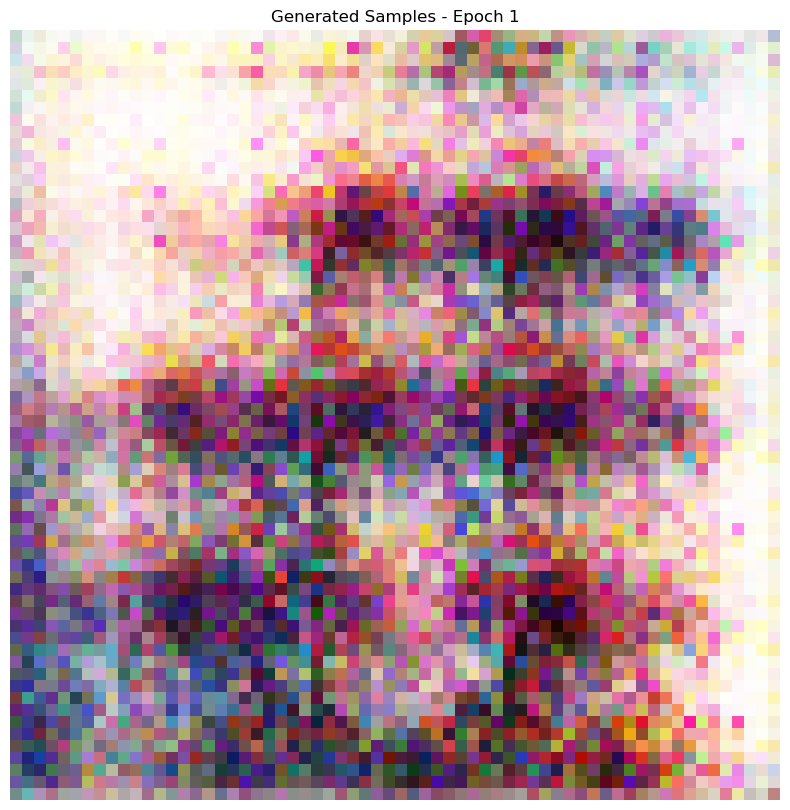

In [57]:
fake_samples = generator(features_reduced).reshape(-1, 3, 64, 64)
# Visualize generated samples
grid_img = vutils.make_grid(fake_samples, nrow=4, padding=2, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.title(f"Generated Samples - Epoch {epoch+1}")
plt.show()